In [1]:
import os
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Download dataset from KaggleHub
dataset_root = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
train_dir = os.path.join(dataset_root, "Training")
test_dir = os.path.join(dataset_root, "Testing")

In [4]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [5]:
# Load datasets
trainval_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
class_names = trainval_dataset.classes

In [6]:
# Split train into train/val
val_size = int(0.15 * len(trainval_dataset))
train_size = len(trainval_dataset) - val_size
train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

In [7]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, name, patience=5):
    best_acc = 0.0
    best_loss = float('inf')
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    early_stop_counter = 0

    for epoch in range(num_epochs):
        # ---------- Training ----------
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        # ---------- Validation ----------
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct_val / total_val

        # ---------- Logging ----------
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # ---------- Save best model ----------
        if val_loss < best_loss:
            best_loss = val_loss
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_brain_tumor_{name}.pth")
            early_stop_counter = 0  # reset if improvement
        else:
            early_stop_counter += 1
            print(f"No improvement in validation loss for {early_stop_counter} epoch(s).")

        # ---------- Early stopping ----------
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    return history


In [9]:
# Testing function
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Test Accuracy: {acc:.4f}")


In [10]:
def visualize_predictions(model, loader, num_images=6):
    model.eval()
    images_shown = 0
    fig = plt.figure(figsize=(12, 6))

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size(0)):
                if images_shown == num_images:
                    plt.tight_layout()
                    return

                ax = fig.add_subplot(2, num_images//2, images_shown + 1)
                img = images[j].cpu().permute(1, 2, 0).numpy()
                img = (img * 0.5 + 0.5).clip(0, 1)  # Unnormalize

                ax.imshow(img)
                true_label = class_names[labels[j]]
                pred_label = class_names[preds[j]]
                ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
                ax.axis('off')

                images_shown += 1

    plt.tight_layout()
    plt.show()

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def evaluate_model(model, loader, class_names, title="Confusion Matrix"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


In [14]:
# Load pretrained MobileNetV2
model2 = models.mobilenet_v2(pretrained=True)
for param in model2.parameters():
    param.requires_grad = False

# Modify classifier
num_ftrs = model2.classifier[1].in_features
model2.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)

model2 = model2.to(device)

In [16]:
# First phase training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.classifier.parameters(), lr=0.001)
history = train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs=60, name='mobilenetv2')

Epoch [1/60] Train Loss: 0.5408, Train Acc: 0.7918 Val Loss: 0.3687, Val Acc: 0.8750
Epoch [2/60] Train Loss: 0.3526, Train Acc: 0.8701 Val Loss: 0.2914, Val Acc: 0.8879
Epoch [3/60] Train Loss: 0.3410, Train Acc: 0.8721 Val Loss: 0.2878, Val Acc: 0.8972
Epoch [4/60] Train Loss: 0.2903, Train Acc: 0.8933 Val Loss: 0.2697, Val Acc: 0.9054
Epoch [5/60] Train Loss: 0.2812, Train Acc: 0.8966 Val Loss: 0.2491, Val Acc: 0.9100
Epoch [6/60] Train Loss: 0.2613, Train Acc: 0.9032 Val Loss: 0.2356, Val Acc: 0.9065
Epoch [7/60] Train Loss: 0.2475, Train Acc: 0.9100 Val Loss: 0.2310, Val Acc: 0.9112
Epoch [8/60] Train Loss: 0.2460, Train Acc: 0.9084 Val Loss: 0.2190, Val Acc: 0.9194
Epoch [9/60] Train Loss: 0.2366, Train Acc: 0.9090 Val Loss: 0.2151, Val Acc: 0.9136
Epoch [10/60] Train Loss: 0.2381, Train Acc: 0.9123 Val Loss: 0.2159, Val Acc: 0.9136
No improvement in validation loss for 1 epoch(s).
Epoch [11/60] Train Loss: 0.2097, Train Acc: 0.9182 Val Loss: 0.2054, Val Acc: 0.9206
Epoch [12/60]

Test Accuracy: 0.9298


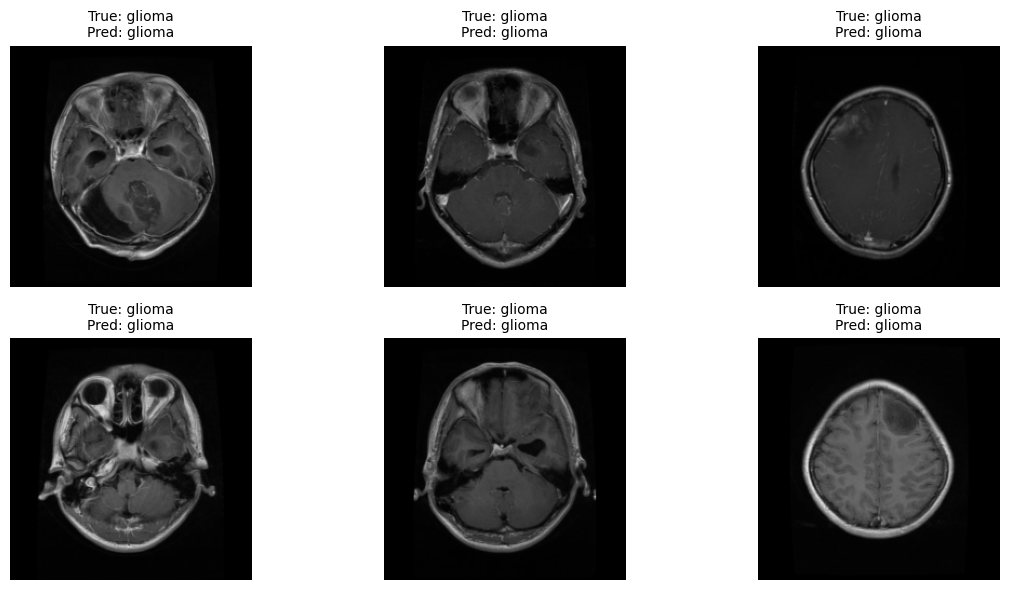

In [19]:
# First test
model2.load_state_dict(torch.load("best_brain_tumor_mobilenetv2.pth"))
test_model(model2, test_loader)
visualize_predictions(model2, test_loader, 6)


Evaluation: Initial MobileNetV2 Model
              precision    recall  f1-score   support

      glioma       0.93      0.89      0.91       300
  meningioma       0.87      0.84      0.85       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.96      0.97      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.93      1311
weighted avg       0.93      0.93      0.93      1311



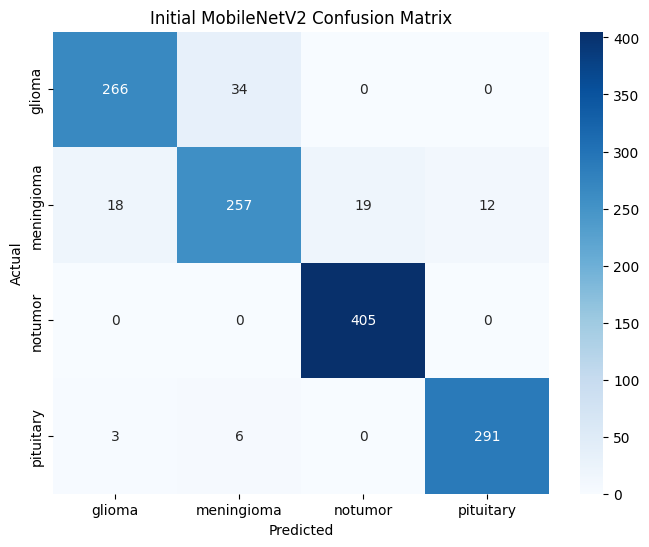

In [20]:
print("\nEvaluation: Initial MobileNetV2 Model")
model2.load_state_dict(torch.load("best_brain_tumor_mobilenetv2.pth"))
evaluate_model(model2, test_loader, class_names, title="Initial MobileNetV2 Confusion Matrix")


In [21]:
# Fine-tuning
for name, param in model2.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=1e-4)
history = train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs=60, name='MobileNetV2_finetuned')

Epoch [1/60] Train Loss: 0.1255, Train Acc: 0.9537 Val Loss: 0.1789, Val Acc: 0.9357
Epoch [2/60] Train Loss: 0.1156, Train Acc: 0.9584 Val Loss: 0.1777, Val Acc: 0.9439
Epoch [3/60] Train Loss: 0.1064, Train Acc: 0.9617 Val Loss: 0.1874, Val Acc: 0.9357
No improvement in validation loss for 1 epoch(s).
Epoch [4/60] Train Loss: 0.1045, Train Acc: 0.9598 Val Loss: 0.1720, Val Acc: 0.9428
Epoch [5/60] Train Loss: 0.1010, Train Acc: 0.9607 Val Loss: 0.1762, Val Acc: 0.9439
No improvement in validation loss for 1 epoch(s).
Epoch [6/60] Train Loss: 0.1006, Train Acc: 0.9648 Val Loss: 0.1795, Val Acc: 0.9416
No improvement in validation loss for 2 epoch(s).
Epoch [7/60] Train Loss: 0.0897, Train Acc: 0.9652 Val Loss: 0.1753, Val Acc: 0.9428
No improvement in validation loss for 3 epoch(s).
Epoch [8/60] Train Loss: 0.0883, Train Acc: 0.9675 Val Loss: 0.1839, Val Acc: 0.9416
No improvement in validation loss for 4 epoch(s).
Epoch [9/60] Train Loss: 0.0963, Train Acc: 0.9648 Val Loss: 0.1777, V

Test Accuracy: 0.9443


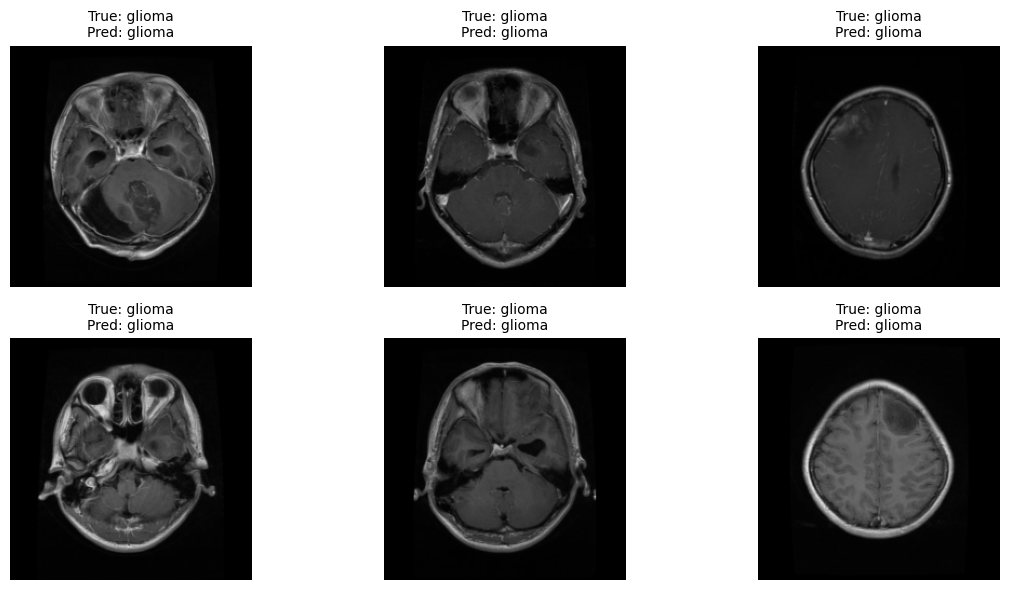

In [22]:
# Final test
model2.load_state_dict(torch.load("best_brain_tumor_MobileNetV2_finetuned.pth"))
test_model(model2, test_loader)
visualize_predictions(model2, test_loader, 6)


Evaluation: Fine-tuned MobileNetV2 Model
              precision    recall  f1-score   support

      glioma       0.96      0.87      0.91       300
  meningioma       0.86      0.92      0.89       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.97      0.97      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.94      0.94      1311



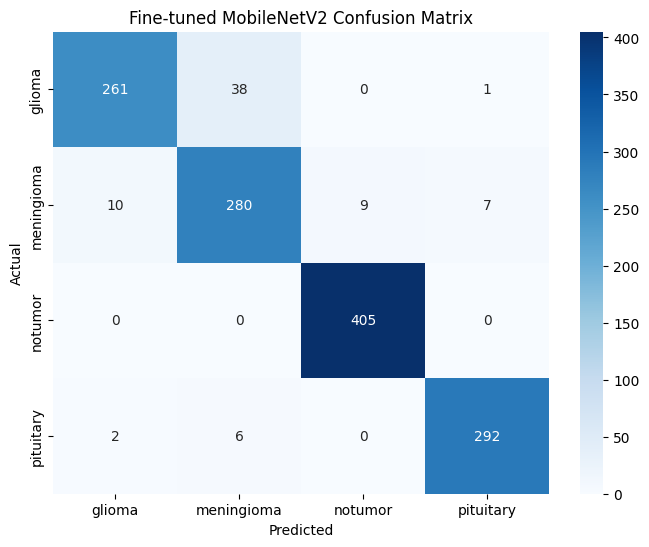

In [23]:
print("\nEvaluation: Fine-tuned MobileNetV2 Model")
model2.load_state_dict(torch.load("best_brain_tumor_MobileNetV2_finetuned.pth"))
evaluate_model(model2, test_loader, class_names, title="Fine-tuned MobileNetV2 Confusion Matrix")
